## Geospatial Analysis Cookbook

SnowEx Hackweek  
July 13, 2021

David Shean

These are some common operations that you may need for your projects. We hope that you can review this code, and copy/paste to use in a modular fashion for your projects, so you don't have to reinvent the wheel when time is limited.

Some of these will run without modification, others were copied from previous tutorials/labs as rendered cells, but have not been updated for sample data used during SnowEx Hackweek. I am hoping to clean these up, but please reach out to discuss if something is confusing or doesn't work.

## Contents
* csv of points to GeoPandas GeoDataFrame
* Exporting GeoDataFrame to GIS-ready file
* Download and mosaic the 1-m USGS 3DEP lidar DTM tiles for Grand Mesa
* Retrieve data from Zenodo archive: WV stereo snow depth for Grand Mesa
* Add day of water year to data frame
* Use OpenTopography API to fetch clipped portion of global DEMs
* Sampling raster or ndarray at points
    * https://github.com/uw-cryo/raster_sampling
* Handling complex coordinate system transformations with pyproj (3D horizontal and vertical, ellipsoid to geoid heights)

## To add (using snippets in other tutorials/labs)
* Zonal statistics for polygons
* Hypsometry and statistics for elevation bands - binning one raster/vector dataset by another, snow depth elevation, snow depth vs. slope
* Clipping a raster by a polygon

# Importing csv of point data

### Load the existing csv into a Pandas DataFrame
* Use the relative path as in previous labs and the amazing Pandas `read_csv()` function
* Run a quick `head()` on your DataFrame to make sure everything looks right

In [17]:
glas_fn = '../01_Shell_Github/data/GLAH14_tllz_conus_lulcfilt_demfilt.csv'
glas_df = pd.read_csv(glas_fn)

In [18]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31


## Convert the Pandas `DataFrame` to a GeoPandas `GeoDataFrame`
* See documentation here: https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
* Careful about lon and lat order!
* Define coordinate reference system with crs keyword argument (4326 is geographic lat/lon on WGS84 Ellispoid) 
    * https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/intro-to-coordinate-reference-systems/
* Store in a variable named `glas_gdf` (needed for sample code later)
* Run a quick `head()` to make sure everything looks good
* You should have a new `geometry` column cointaining shapely Point objects

In [19]:
glas_gdf = gpd.GeoDataFrame(glas_df, geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']), crs='EPSG:4326')

# Save processed data to a GIS-ready file

The workflows in these Notebooks are intended to be fully reproducible, starting with raw data and producing all final output.  But sometimes you want to write out geospatial data for analysis in a GUI-based GIS (QGIS, ArcMap), or to share with colleagues who will use these tools.

## Check available output formats for geopandas
* Use fiona to get a list of available file type drivers for output
* Note: the 'r' means fiona/geopandas can read this file type, 'w' means it can write this file type, 'a' means it can append to an existing file.
    * https://fiona.readthedocs.io/en/latest/manual.html#writing-vector-data

In [75]:
import fiona
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'rw',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

## How to choose a format?
* If you've taken a GIS class (or not), you've probably used shapefiles in the past.  Please stop.  The ESRI shapefile is a legacy format, though it is still widely used.
* http://switchfromshapefile.org/
* Better options these days are Geopackage (GPKG) when spatial index is required, and simple GeoJSON for vector data in EPSG:4326
    * Both should be supported by your GIS (including QGIS, ArcGIS, etc)
* Let's use geopackage for this exercise
* Can use the Geopandas `to_file()` method to create this file
    * Make sure you properly specify filename with extension and the `driver` option
    * *Note: Writing out may take a minute, and may produce an intermediate '.gpkg-journal' file*
        * Can see this in the file browser or terminal!

In [134]:
out_fn='./conus_glas_gdf_aea_rgi_agg.gpkg'
glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GPKG')

#out_fn='./conus_glas_gdf_aea_rgi_agg.geojson'
#glas_gdf_aea_rgi_agg_gdf.to_file(out_fn, driver='GeoJSON')

In [135]:
ls -lh $out_fn

-rw-r--r-- 1 jovyan jovyan 816K Aug 18 18:29 ./conus_glas_gdf_aea_rgi_agg.gpkg


## 🎉

You can now directly load this gpkg file in any GIS, without defining a coordinate system. You can also load this file directly into geopandas in the future using the `read_file()` method, without having to repeat the processing above.

### See for yourself!
Try it! Right-click on file in the file browser to the left of the JupyterLab interface, then select Download and pick a location on your local computer (e.g., your Downloads folder). 

Then open this file in QGIS or ArcGIS on your local machine!

# USGS 3DEP Raster Tile Download - Mesa County LiDAR

In [4]:
import os
import rasterio as rio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt

In [1]:
#Current url for 1/9th arcsec 3DEP raster products
#url1='https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n48x25_w122x50_wa_puget_sound_2000.zip'
#fn1='ned19_n48x25_w122x50_wa_puget_sound_2000.img'
#Going to fetch and read zipfile on the fly, specifying img inside
#path=f'/vsizip//vsicurl/{url1}/{fn1}'
#os.path.splitext(os.path.split(url_list[0])[-1])[0]+'.img'

In [36]:
#GUI based search for tiles
#https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html
#Contains public url for each tif
url_fn_3DEP = 'gm_3dep_1m_lidar_tiles.txt'

In [32]:
with open(url_fn_3DEP) as f:
    url_list = f.read().splitlines()

In [34]:
url_list.sort()

In [28]:
#idx = ['UTM13' in i for i in url_list]

In [8]:
path_list = []
for url in url_list:
    #fn = os.path.splitext(os.path.split(url)[-1])[0]+'.img'
    #path = f'/vsizip//vsicurl/{url}/{fn}'
    path = f'/vsicurl/{url}'
    path_list.append(path)
path_list_str = ' '.join(path_list)

In [9]:
path

'/vsicurl/https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM13_2015/TIFF/USGS_one_meter_x76y434_CO_MesaCo_QL2_UTM13_2015.tif'

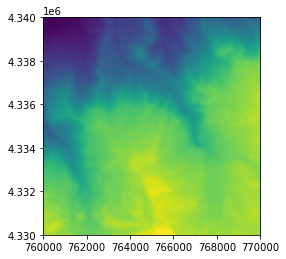

In [13]:
with rio.open(path) as src:
    rio.plot.show(src)

In [5]:
url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/CO_MesaCo_QL2_UTM12_2016/TIFF/USGS_one_meter_x74y433_CO_MesaCo_QL2_UTM12_2016.tif'

In [6]:
path = f'/vsicurl/{url}'

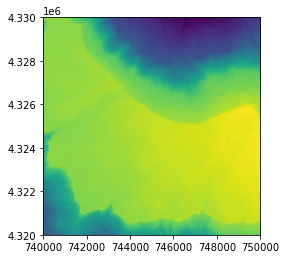

In [7]:
with rio.open(path) as src:
    rio.plot.show(src)

In [37]:
vrt_fn = os.path.splitext(url_fn_3DEP)[0]+'.vrt'
tif_fn = os.path.splitext(url_fn_3DEP)[0]+'.tif'
hs_fn = os.path.splitext(tif_fn)[0]+'_hs.tif'

In [ ]:
#This actually takes some time as file must be downloaded and unzipped to read img header
!gdalbuildvrt $vrt_fn $path_list_str

In [36]:
dst_crs = 'EPSG:32612'

In [ ]:
#Since these tiles are mixed projection, can download, reproject and mosaic in one go
!gdalwarp -r cubic -tr 3.0 3.0 -dstnodata -9999 -t_srs $dst_crs \
-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER \
$path_list_str $tif_fn

In [38]:
!gdaldem hillshade -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $tif_fn $hs_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [39]:
!gdaladdo -r gauss $hs_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [50]:
src = rio.open(hs_fn, overview_level=1)

In [51]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 4969, 'height': 3496, 'count': 1, 'crs': CRS.from_epsg(32612), 'transform': Affine(11.99939625679211, 0.0, 729993.5474426108,
       0.0, -11.997425629290618, 4341936.375353689), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

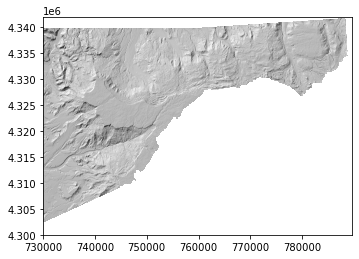

<AxesSubplot:>

In [55]:
rio.plot.show(src, cmap='gray')

# Retrieve Preliminary Feb 2017 Grand Mesa WorldView Stereo Snow Depth data product from Zenodo repository
* Snow depth raster derived from WorldView-3 DEMs for comparisons in McGrath et al. (2019) against ASO lidar snow depth, GPR snow depth and snow pit data
* https://doi.org/10.5281/zenodo.3381652

In [77]:
# https://zenodo.org/record/3381653
url = 'https://zenodo.org/record/3381653/files/20160925_gm_8m_trans-tile-0_20170201_gm_8m_trans-tile-0_dz_eul.tif'

In [78]:
#This uses the GDAL /vsicurl_streaming approach
test_fn = f'/vsicurl_streaming/{url}'

In [79]:
src = rio.open(test_fn)

In [80]:
src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 3058, 'height': 3587, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(8.507909317409881, 0.0, 215541.735564,
       0.0, -8.507909317409881, 4337507.131849696), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [81]:
a = src.read(1, masked=True)

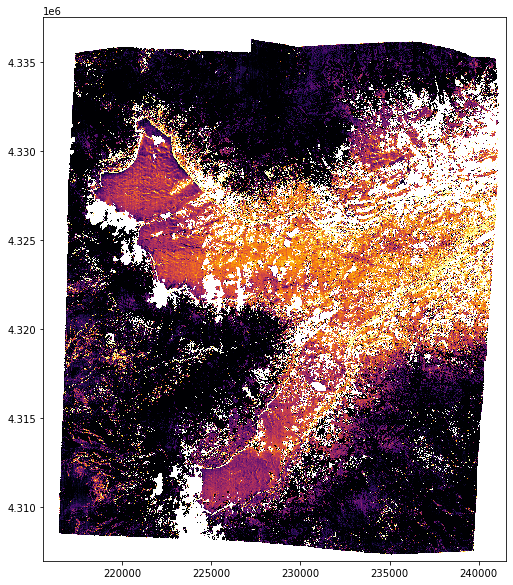

In [84]:
f, ax = plt.subplots(figsize=(10,10))
ax.imshow(a, cmap='inferno', clim=(0, 2), interpolation='none', extent=rio.plot.plotting_extent(src))

## Function to add day of year and day of water year to dataframe

In [74]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365
    df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear

## Clean up ASO DTM and Snow Depth data from NSIDC

In [33]:
aso_dir = '/nobackupp8/deshean/data/ASO'
aso_fn_list = !ls $aso_dir/ASO*SD*tif $aso_dir/ASO*DTM*tif
aso_fn_list

['/nobackupp8/deshean/data/ASO/ASO_3M_PCDTM_USCOGM_20160926_20160926.tif',
 '/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_20170208.tif',
 '/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_20170216.tif',
 '/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_20170220.tif',
 '/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_20170221.tif',
 '/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_20170225.tif']

## Prepare polygon masks around valid data in raster
* This is a common task to generate polygons around valid pixels in a raster
* Can do this on a low-resolution overview (8x subsampling) for efficiency

In [34]:
aso_feat_list = []
ovr_scale = 8
for fn in aso_fn_list:
    src = rio.open(fn)
    a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
    ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
    mask = np.ma.getmaskarray(a).astype(np.uint8) - 1
    shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
    geom_list = list(shapes)
    dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-1]
    aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])

In [35]:
aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
aso_gdf = aso_gdf.to_crs(crs)

<AxesSubplot:>

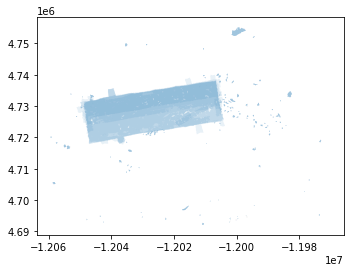

In [36]:
aso_gdf.plot(alpha=0.1)

In [37]:
#remove tiny polygons
area_thresh = 1e8
aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]

<AxesSubplot:>

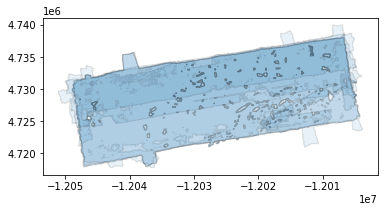

In [38]:
aso_gdf.plot(alpha=0.1, edgecolor='k', legend=True)

In [39]:
#Shoud simplify and sieve
#aso.geometry.simplify(tolerance=100)

In [40]:
aso_gdf['date'] = pd.to_datetime(aso_gdf['date'])

In [41]:
add_dowy(aso_gdf, col='date')

Adding Day of Water Year (DOWY)


In [42]:
aso_gdf['platform'] = 'ASO'
aso_gdf['acqdate'] = aso_gdf['date']

In [43]:
aso_gdf.set_index('date', inplace=True)

In [44]:
aso_gdf

,geometry,fn,doy,dowy,decyear,platform,acqdate
date,,,,,,,
2016-09-26,"POLYGON ((-12015160.592 4739071.493, -12015159...",/nobackupp8/deshean/data/ASO/ASO_3M_PCDTM_USCO...,270,362,2016.734973,ASO,2016-09-26
2017-02-08,"POLYGON ((-12006926.162 4738034.310, -12006925...",/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_...,39,131,2017.104110,ASO,2017-02-08
2017-02-16,"POLYGON ((-12006924.216 4737972.309, -12006923...",/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_...,47,139,2017.126027,ASO,2017-02-16
2017-02-20,"POLYGON ((-12007497.441 4738512.728, -12007496...",/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_...,51,143,2017.136986,ASO,2017-02-20
2017-02-21,"POLYGON ((-12008378.907 4740005.456, -12008374...",/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_...,52,144,2017.139726,ASO,2017-02-21
2017-02-25,"POLYGON ((-12006670.686 4738756.138, -12006667...",/nobackupp8/deshean/data/ASO/ASO_3M_SD_USCOGM_...,56,148,2017.150685,ASO,2017-02-25


# Strategies for Dynamic DEM Data Download and Processing

In [85]:
import os
import requests
import rasterio as rio
from rasterio import plot, mask

In [86]:
gm_bounds = [-108.34115668,   38.82320553, -107.72839859,   39.19563035]

## Use OpenTopography GlobalDEM API to fetch clipped DEM
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* Latest list of available DEM: https://portal.opentopography.org/apidocs/#/Public/getGlobalDem
* We'll use this service to extract a small portion of the SRTM-GL3 DEM

In [59]:
#List of all products hosted by OpenTopography GlobalDEM API
demtype_list = ["SRTMGL3", "SRTMGL1", "SRTMGL1_E", "AW3D30", "AW3D30_E", "SRTM15Plus"]

In [55]:
#1 arcsec
demtype = "SRTMGL1_E"

In [56]:
base_url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [57]:
base_url.format(demtype, *gm_bounds)

'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1_E&west=-108.34115668&south=38.82320553&east=-107.72839859&north=39.19563035&outputFormat=GTiff'

### Optional: set up API key to access Copernicus DEM and NASADEM
* This will enable access to NASADEM and Compernicus DEM (30 and 90 m)
* https://portal.opentopography.org/myopentopo

In [65]:
#Paste API key below
api_key = None
if api_key:
    demtype_list.extend(['NASADEM', 'COP30', 'COP90'])
    demtype = 'COP30'

In [66]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None, api_key=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, *bounds)
        if api_key is not None:
            url = f'{url}&API_Key={api_key}'
        print(url)
        #Get
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)

In [67]:
out_fn = f"GM_{demtype}.tif"
out_fn

'GM_SRTMGL1_E.tif'

In [68]:
get_OT_GlobalDEM(demtype, gm_bounds, out_fn, api_key)

https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1_E&west=-108.34115668&south=38.82320553&east=-107.72839859&north=39.19563035&outputFormat=GTiff


In [72]:
!ls -lh $out_fn

-rw-r--r-- 1 jovyan users 8.9M Jul 10 14:22 GM_SRTMGL1_E.tif


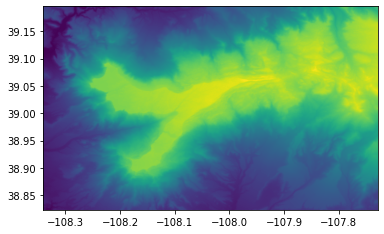

In [73]:
with rio.open(out_fn) as src:
    rio.plot.show(src)

# Sampling a raster at points

### Reproject points to match raster

In [155]:
glas_gdf_srtm = glas_gdf_aea.to_crs(srtm_src.crs)

### Prepare the coordinate arrays to pass to rio `sample` function
* The `sample` function expects a list of (x,y) tuples: https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html
    * Need to create this from the `geometry` objects in your GeoDataFrame
    * You want a list of the form [(x1,y1),(x2,y2),…]
* Pass to `sample`
* Note that the `sample` function returns a `generator` object, and it doesn't actually evaluate the call!
* Can wrap this in a `np.array(list())` to evaluate, or use `np.fromiter()`
* This operation may take ~10-20 seconds to complete

In [156]:
glas_coord = [(pt.x, pt.y) for pt in glas_gdf_srtm.geometry]
#glas_coord = np.vstack((glas_gdf_srtm.geometry.x.values, glas_gdf_srtm.geometry.y.values)).T

### Sample with rasterio

In [157]:
glas_srtm_sample = srtm_src.sample(glas_coord)
glas_srtm_sample

<generator object sample_gen at 0x7f292c4065d0>

### This is a generator, so we actually need to evaluate

In [158]:
glas_srtm_elev = np.fromiter(glas_srtm_sample, dtype=srtm.dtype)
glas_srtm_elev

array([-32768, -32768, -32768, ..., -32768, -32768, -32768], dtype=int16)

### Deal with nodata
* Some of our GLAS points are located over areas where we don't have valid DEM pixels
* These will be assigned the raster nodata value (-32768 in this case)

In [159]:
glas_srtm_elev_ma = np.ma.masked_equal(glas_srtm_elev, srtm_src.nodata)
glas_srtm_elev_ma

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=-32768,
            dtype=int16)

### Add new column to the GeoDataFrame
* Set masked values to `np.nan` (which requires a conversion to float)

In [160]:
glas_gdf_srtm['srtm_90m_z_rio'] = glas_srtm_elev_ma.astype(float).filled(np.nan)

In [161]:
glas_gdf_srtm.dropna().head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry,srtm_90m_z_rio
465,2003.143756,731268.470836,46.279402,-124.035117,-23.42,-22.25,0.81,31,-1.17,3.031756,-0.385915,POINT (420253.074 5125612.379),0.0
466,2003.143756,731268.470836,46.282470,-124.035774,-23.39,-21.81,0.52,31,-1.58,3.031756,-0.521150,POINT (420206.912 5125953.931),1.0
467,2003.143756,731268.470838,46.291775,-124.037745,-23.44,-23.53,0.00,31,0.09,3.031756,0.029686,POINT (420068.610 5126989.811),0.0
468,2003.143756,731268.470838,46.293329,-124.038072,-23.11,-23.54,0.00,31,0.43,3.031756,0.141832,POINT (420045.685 5127162.809),0.0
469,2003.143756,731268.470838,46.294880,-124.038399,-23.98,-22.78,0.26,31,-1.20,3.031756,-0.395810,POINT (420022.757 5127335.473),0.0


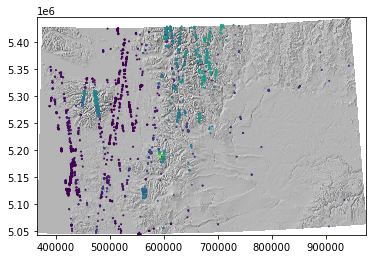

In [162]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=rio.plot.plotting_extent(srtm_hs_src))
#ax.imshow(srtm, extent=srtm_extent, alpha=0.5);
glas_gdf_srtm.dropna().plot('srtm_90m_z_rio', ax=ax, markersize=1);

*Note: the SRTM elevation values are height above the EGM96 geoid*

### Notes on sampling coarse rasters or noisy rasters at integer pixel locations
* The rasterio approach is efficient, but it uses a nearest neighbor algorithm to extract the elevation value for the grid cell that contains the point, regardless of where the point falls within the grid cell (center vs. corner)
* But the DEM grid cells can be big (~90x90 m for the SRTM3 data), so if point is near the corner of a pixel on steep slope, the pixel value might not be representative.
* A better approach is to use bilinear or bicubic sampling, to interpolate the elevation value at the point coordinate using pixel values within some neighborhood around the point, (e.g. 2x2 window for bilinear, 4x4 window for cubic)
* Other approaches involve computing zonal stats within some radius of the point location (e.g., median elevation of pixels within 300 m of the point, using buffer to create polygons)
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/
    * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html#getting-values-at-cells
    * https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019

## 2. Local window sample

https://github.com/dshean/demcoreg/blob/master/demcoreg/sample_raster_at_pts.py

https://github.com/dshean/pygeotools/blob/master/pygeotools/lib/geolib.py#L1019

## 3. Scipy ndimage: n-order polynomial
* Good option for regular grids (i.e., DEMs)
* Propagates nan, issues when DEM has missing data

In [163]:
import scipy.ndimage
#Should dropna here
yx = np.array([glas_gdf_srtm.geometry.y, glas_gdf_srtm.geometry.x])
#Convert map coordinates to array coordinates (want float, not whole integer indices)
#See functions here
#https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html
#Need to revisit
#Use bilinear resampling here (order=1)
ndimage_samp = scipy.ndimage.map_coordinates(srtm, yx, order=1, mode='nearest')
ndimage_samp = np.ma.masked_equal(ndimage_samp, srtm_src.nodata)

In [164]:
srtm_src.transform

Affine(68.74846185120099, 0.0, 364652.9635476386,
       0.0, -68.74846185120099, 5445635.966252405)

In [165]:
glas_gdf_srtm['srtm_90m_z_ndimage'] = ndimage_samp.astype(float).filled(np.nan)

In [166]:
glas_gdf_srtm.dropna().head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,glas_srtm_dh,glas_srtm_dt,glas_srtm_dhdt,geometry,srtm_90m_z_rio,srtm_90m_z_ndimage


## Handling complex horizontal and vertical datum transformations
* https://pyproj4.github.io/pyproj/stable/build_crs.html

In [49]:
import pyproj
from pyproj.crs import CRS, CompoundCRS

## 2D WGS84 coordinates (lat, lon)

In [52]:
CRS(4326)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 3D WGS84 coordinates (lat, lon, height above ellipsoid)

In [53]:
CRS(4979)

<Geographic 3D CRS: EPSG:4979>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World: Afghanistan, Albania, Algeria, American Samoa, Andorra, Angola, Anguilla, Antarctica, Antigua and Barbuda, Argentina, Armenia, Aruba, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belgium, Belgium, Belize, Benin, Bermuda, Bhutan, Bolivia, Bonaire, Saint Eustasius and Saba, Bosnia and Herzegovina, Botswana, Bouvet Island, Brazil, British Indian Ocean Territory, British Virgin Islands, Brunei Darussalam, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Canada, Cape Verde, Cayman Islands, Central African Republic, Chad, Chile, China, Christmas Island, Cocos (Keeling) Islands, Comoros, Congo, Cook Islands, Costa Rica, Côte d'Ivoire (Ivory Coast), Croatia, Cuba, Curacao, Cyprus, Czechia, Denmark, Djibouti, Dominica, Dominican Republic, East Timor, Ec

In [68]:
CRS(7789)

<Geocentric CRS: EPSG:7789>
Name: ITRF2014
Axis Info [cartesian]:
- X[geocentricX]: Geocentric X (metre)
- Y[geocentricY]: Geocentric Y (metre)
- Z[geocentricZ]: Geocentric Z (metre)
Area of Use:
- name: World: Afghanistan, Albania, Algeria, American Samoa, Andorra, Angola, Anguilla, Antarctica, Antigua and Barbuda, Argentina, Armenia, Aruba, Australia, Austria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belgium, Belgium, Belize, Benin, Bermuda, Bhutan, Bolivia, Bonaire, Saint Eustasius and Saba, Bosnia and Herzegovina, Botswana, Bouvet Island, Brazil, British Indian Ocean Territory, British Virgin Islands, Brunei Darussalam, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Canada, Cape Verde, Cayman Islands, Central African Republic, Chad, Chile, China, Christmas Island, Cocos (Keeling) Islands, Comoros, Congo, Cook Islands, Costa Rica, Côte d'Ivoire (Ivory Coast), Croatia, Cuba, Curacao, Cyprus, Czechia, Denmark, Djibouti, Dominica, Dominican Republic, East Timor, Ecuado

In [71]:
CRS("EPSG:32610").to_3d()

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [72]:
CRS("EPSG:32610").to_3d()

<Projected CRS: PROJCRS["WGS 84 / UTM zone 10N",BASEGEOGCRS["WGS 8 ...>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
cmpd_crs = CompoundCRS(name="NAD83 + NAVD88", components=["EPSG:4269", "EPSG:5703"])
cmpd_crs = CRS("EPSG:4269+5703")
#cmpd_crs = CompoundCRS(name="WGS 84 + EGM96", components=["EPSG:4326", "EPSG:5773"])
#cmpd_crs = CRS("EPSG:4326+5773")

In [55]:
cmpd_crs

<Compound CRS: EPSG:5498>
Name: NAD83 + NAVD88 height
Axis Info [ellipsoidal|vertical]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- H[up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Sub CRS:
- NAD83
- NAVD88 height

In [35]:
gm_centroid = (39.02687, -108.06352, 0)

In [66]:
#(y, x, z, t)
snotel_coord = (39.05831, -108.05835, 3048, 2010.0)

In [64]:
trans = pyproj.Transformer.from_crs(cmpd_crs, "EPSG:4979")
trans.transform(*snotel_coord)

(39.05831689247341, -108.0583632291442, 3031.5869785975665, 2019.0)

In [67]:
trans = pyproj.Transformer.from_crs(cmpd_crs, "EPSG:4979")
trans.transform(*snotel_coord)

(39.05831689247341, -108.0583632291442, 3031.5869785975665, 2010.0)

In [58]:
trans = pyproj.Transformer.from_crs(cmpd_crs, "EPSG:32612")
trans.transform(*snotel_coord)

(754535.5223459359, 4327367.315089998, 3032.4354813075925)

In [60]:
trans = pyproj.Transformer.from_crs(cmpd_crs, "EPSG:26912")
trans.transform(*snotel_coord)

(754536.692027982, 4327366.586966569, 3032.4354813075925)

In [61]:
trans = pyproj.Transformer.from_crs(cmpd_crs, "EPSG:26912+5703")
trans.transform(*snotel_coord)

(754536.692027982, 4327366.586966569, 3048.0)

In [62]:
CRS(26912)

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan.  United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [46]:
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

aoi = AreaOfInterest(west_lon_degree=gm_centroid[1], 
                     south_lat_degree=gm_centroid[0],
                     east_lon_degree=gm_centroid[1],
                     north_lat_degree=gm_centroid[0])

utm_crs_list = query_utm_crs_info(datum_name="NAD83", area_of_interest=aoi)

utm_crs = CRS.from_epsg(utm_crs_list[0].code)

In [45]:
utm_crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan.  United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Vertical conversion using PROJ and GDAL
* Try proj `+nadgrids=` instead of `+grids=`?

In [ ]:
Attempts to convert from NAD83+NAVD88 to WGS84+ellipsoid

In [ ]:
gdalwarp -overwrite -s_srs EPSG:26912+5703 -t_srs '+proj=utm +zone=12 +datum=WGS84 +units=m +no_defs +type=crs +grids=us_noaa_g2018u0.tif' USGS_one_meter_
x74y432_CO_MesaCo_QL2_UTM12_2016.tif test.tif

In [ ]:
gdalwarp -overwrite -s_srs 'EPSG:26912+5703' -t_srs 'EPSG:32612+4979' USGS_one_meter_x74y432_CO_MesaCo_QL2_UTM12_2016.tif test3.tif